In [2]:
from nonasymptotic.envs import StraightLine
from nonasymptotic.prm import SimplePRM

import matplotlib.pyplot as plt
import numpy as np

env: OMPL_PATH=/home/seiji/Research/ompl/py-bindings


In [3]:
prm_env_2d = StraightLine(dim=2, delta_clearance=0.5)
prm = SimplePRM(0.2, prm_env_2d.is_motion_valid, prm_env_2d.sample_from_env)
prm.grow_to_n_samples(10000)

# plt.figure()
# for u, v in prm.g_prm.iterEdges():
#     coords_u = prm.samples[u]
#     coords_v = prm.samples[v]
# 
#     plt.plot([coords_u[0], coords_v[0]], [coords_u[1], coords_v[1]], 'ro-')
# 
# plt.show()

# some other computations to help other visual tests later on:
print('N Components: %i' % len(prm.g_cc.getComponents()))
print('N nodes: %i' % prm.num_vertices())
print('N edges: %i' % prm.num_edges())


Tue Jan  9 11:53:50 2024 Building RP forest with 15 trees
Tue Jan  9 11:53:53 2024 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	Stopping threshold met -- exiting after 2 iterations
Tue Jan  9 11:54:00 2024 Worst tree score: 0.99680000
Tue Jan  9 11:54:00 2024 Mean tree score: 0.99804000
Tue Jan  9 11:54:00 2024 Best tree score: 0.99860000
Tue Jan  9 11:54:02 2024 Forward diversification reduced edges from 200000 to 41658
Tue Jan  9 11:54:04 2024 Reverse diversification reduced edges from 41658 to 41658
Tue Jan  9 11:54:05 2024 Degree pruning reduced edges from 36650 to 36650
Tue Jan  9 11:54:05 2024 Resorting data and graph based on tree order
Tue Jan  9 11:54:05 2024 Building and compiling search function
N Components: 1
N nodes: 10000
N edges: 61739


N nodes: 10000
N edges: 61676


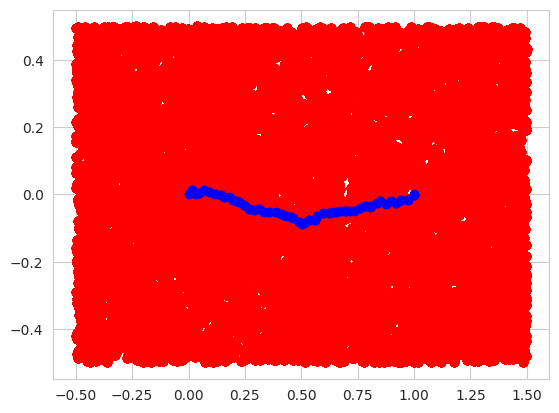

In [3]:
# do some connection queries with some existing points
s = np.array([0., 0.])
g = np.array([1., 0.])

sol_dist, sol_path = prm.query_best_solution(s, g)
sol_path = np.concatenate([[s], sol_path, [g]])

plt.figure()

# plot the existing prm
for u, v in prm.g_prm.iterEdges():
    coords_u = prm.samples[u]
    coords_v = prm.samples[v]

    plt.plot([coords_u[0], coords_v[0]], [coords_u[1], coords_v[1]], 'ro-')

for i in range(sol_path.shape[0] - 1):
    u = sol_path[i]
    v = sol_path[i+1]
    plt.plot([u[0], v[0]], [u[1], v[1]], 'bo-')

plt.plot()
print('N nodes: %i' % prm.num_vertices())
print('N edges: %i' % prm.num_edges())


In [ ]:
pairs, _ = prm.query_all_graph_connections(s, g)
plt.figure()

# plot the existing prm
for u, v in prm.g_prm.iterEdges():
    coords_u = prm.samples[u]
    coords_v = prm.samples[v]

    plt.plot([coords_u[0], coords_v[0]], [coords_u[1], coords_v[1]], 'ro-')
    
for u, v in pairs:
    plt.plot([u[0], v[0]], [u[1], v[1]], 'bo-')
    
plt.show()


In [5]:
# just testing to see if we can compute the shortest paths

line_dir = np.array([1.0] + [0.0] * (prm_env_2d.dim - 1)).reshape(1, -1)

# use an SDF to filter the prm points
# first, project to the line (use fact that line param is 0->1 in d0):
samples_proj_clip = np.clip(prm.samples[:, 0], 0.0, 1.0).reshape(-1, 1)
within_conn_r_of_line = np.linalg.norm(prm.samples - samples_proj_clip * line_dir, axis=1) <= prm.conn_r
samples_in_conn_r = prm.samples[within_conn_r_of_line]
samples_ids_in_conn_r = np.arange(prm.samples.shape[0])[within_conn_r_of_line]

import networkit as nk
spsp = nk.distance.SPSP(prm.g_prm, samples_ids_in_conn_r)
spsp.setTargets(samples_ids_in_conn_r)
spsp.run()

spsp.getDistance(samples_ids_in_conn_r[0], samples_ids_in_conn_r[1])
spsp.getDistance(samples_ids_in_conn_r[5], samples_ids_in_conn_r[2])


0.48392997216433287

In [ ]:
prm_env_2d.is_prm_epsilon_delta_complete(prm, 0.2, n_samples_per_check=1000, timeout=60.0, vis=True)